### Data Encoding & Multiclass Classification Neural Network for Attack IDS V2 - CIIC Research - José P. Areia

In [1]:
# Tensorflow logging: OFF
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
# Pre-processing & Data Encoding
import pandas as pd
from scipy.stats import zscore

# Import dataset
df = pd.read_csv("Datasets/Anomalous_Traffic_VF.csv")

# Fields for dummy encode
dummy_fields = [
    'frame.protocols', 'coap.payload_length', 'coap.opt.uri_path', 'coap.opt.length', 'ipv6.nxt',
    'icmpv6.rpl.opt.type', 'coap.code'
]

# Fields to fill with 0
fill_fields_0 = [
    'icmpv6.type', 'icmpv6.rpl.opt.length', 'icmpv6.checksum.status', 'udp.length', 'icmpv6.rpl.dio.version',
    'icmpv6.rpl.dio.rank', 'ipv6.plen', 'frame.len', 'icmpv6.rpl.dio.dtsn'
]

# Fields to fill with -1
fill_fields_1 = [
    '6lowpan.iphc.m', 'coap.type', '6lowpan.iphc.nh', 'icmpv6.code', 'icmpv6.rpl.opt.transit.pathlifetime'
]

# Fields to zscore normalization
zscore_fields = [
    'wpan.frame_length', 'frame.cap_len', 'icmpv6.rpl.opt.length', 'udp.length', 'icmpv6.rpl.dio.version',
    'icmpv6.rpl.dio.rank', 'ipv6.plen', 'frame.len', 'icmpv6.rpl.dio.dtsn'
]

# Convert fields to dummy variables
def dummy_encode(df, fields):
    for i in fields:
        df = pd.concat([df, pd.get_dummies(df[i], prefix = i)], axis = 1)
        df.drop(i, axis = 1, inplace = True)
    return df

# Fill empty cells with n value
def fill_fields(df, fields, n):
    for i in fields:
        df[i] = df[i].fillna(n)
    return df
        
# Extract the CoAP Payload length into a new column
def coap_payload_length(df):
    df[["coap.payload", "coap.payload.format", "coap.payload_length"]] = df["coap.payload"].str.split(':', expand = True)
    df["coap.payload_length"] = df["coap.payload_length"].fillna(0)
    df.drop('coap.payload', axis = 1, inplace = True)
    df.drop('coap.payload.format', axis = 1, inplace = True)
    return df

# Zscore normalization
def zscore_normalization(df, fields):
    for i in fields:
        df[i] = zscore(df[i])
    return df
        
fill_fields(df, fill_fields_0, 0)
fill_fields(df, fill_fields_1, -1)

df['icmpv6.type'] = df['icmpv6.type'].replace(155, 1)
df['coap.type'] = df['coap.type'].replace(2, 1)
df['icmpv6.rpl.opt.transit.pathlifetime'] = df['icmpv6.rpl.opt.transit.pathlifetime'].replace(30, 1)

coap_payload_length(df)
zscore_normalization(df, zscore_fields)
df = dummy_encode(df, dummy_fields)

print(f'[DONE] Pre-processing & Data Encoding -- PART 01')

[DONE] Pre-processing & Data Encoding -- PART 01


In [3]:
# Classification for different ports range

# 1 - Well-Known Ports
# 2 - Registered Ports
# 3 - Private or Dynamic Ports

def src_port_range(port):
    if port['prt_src'] < 1024:
        return 1
    if port['prt_src'] < 49151:
        return 2
    if port['prt_src'] < 65535:
        return 3

def dst_port_range(port):
    if port['prt_dst'] < 1024:
        return 1
    if port['prt_dst'] < 49151:
        return 2
    if port['prt_dst'] < 65535:
        return 3

df['prt_src'] = df['udp.srcport']
df['prt_dst'] = df['udp.dstport']

df['src_port'] = df.apply (lambda row: src_port_range(row), axis = 1)
df = pd.concat([df, pd.get_dummies(df['src_port'], prefix="src_port_range")], axis = 1)
df.drop('prt_src', axis = 1, inplace = True)
df.drop('udp.srcport', axis = 1, inplace = True)
df.drop('src_port', axis = 1, inplace = True)

df['dst_port'] = df.apply (lambda row: dst_port_range(row), axis = 1)
df = pd.concat([df, pd.get_dummies(df['dst_port'], prefix = "dst_port_range")], axis = 1)
df.drop('prt_dst', axis = 1, inplace = True)
df.drop('udp.dstport', axis = 1, inplace = True)
df.drop('dst_port', axis = 1, inplace = True)

print(f'[DONE] Pre-processing & Data Encoding -- PART 02')

[DONE] Pre-processing & Data Encoding -- PART 02


In [4]:
import numpy as np

# Convert to Numpy Multiclass Classification
x_columns = df.columns.drop('is_malicious')
x = df[x_columns].values

dummies = pd.get_dummies(df['is_malicious'])
attack = dummies.columns
y = dummies.values

print(f'[DONE] Numpy Multiclass Classification')

[DONE] Numpy Multiclass Classification


In [5]:
from sklearn.model_selection import train_test_split

# Training validation splitting 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 42)

print(f'[DONE] Training validation splitting')

[DONE] Training validation splitting


In [6]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

# Neural Network Model
model = Sequential()
model.add(Dense(50, input_dim = x.shape[1], activation = 'relu')) # Hidden 1
model.add(Dense(25, activation = 'relu')) # Hidden 2
model.add(Dense(y.shape[1], activation = 'softmax')) # Output
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

print(f'[DONE] Neural Network Model')

# Early Stopping
monitor = EarlyStopping(monitor = 'val_loss', min_delta = 1e-3, patience = 10, verbose = 1, mode = 'auto', restore_best_weights = True)
model.fit(x_train, y_train, validation_data = (x_test, y_test), callbacks = [monitor], verbose = 2, epochs = 1000)

print(f'[DONE] Early Stopping')

[DONE] Neural Network Model
Epoch 1/1000
15662/15662 - 21s - loss: 0.0025 - val_loss: 1.1677e-08 - 21s/epoch - 1ms/step
Epoch 2/1000
15662/15662 - 20s - loss: 1.3130e-09 - val_loss: 3.5680e-12 - 20s/epoch - 1ms/step
Epoch 3/1000
15662/15662 - 19s - loss: 4.7573e-13 - val_loss: 0.0000e+00 - 19s/epoch - 1ms/step
Epoch 4/1000
15662/15662 - 18s - loss: 0.0000e+00 - val_loss: 0.0000e+00 - 18s/epoch - 1ms/step
Epoch 5/1000
15662/15662 - 18s - loss: 0.0000e+00 - val_loss: 0.0000e+00 - 18s/epoch - 1ms/step
Epoch 6/1000
15662/15662 - 18s - loss: 0.0000e+00 - val_loss: 0.0000e+00 - 18s/epoch - 1ms/step
Epoch 7/1000
15662/15662 - 18s - loss: 0.0000e+00 - val_loss: 0.0000e+00 - 18s/epoch - 1ms/step
Epoch 8/1000
15662/15662 - 18s - loss: 0.0000e+00 - val_loss: 0.0000e+00 - 18s/epoch - 1ms/step
Epoch 9/1000
15662/15662 - 18s - loss: 0.0000e+00 - val_loss: 0.0000e+00 - 18s/epoch - 1ms/step
Epoch 10/1000
15662/15662 - 18s - loss: 0.0000e+00 - val_loss: 0.0000e+00 - 18s/epoch - 1ms/step
Epoch 11/1000
R

In [7]:
# Prediction
pred = model.predict(x_test)

5221/5221 [==============================] - 5s 909us/step


In [8]:
from sklearn import metrics

# Metrics for the classification
def compute_metrics(pred, y_test):
    predict_classes = np.argmax(pred, axis = 1)
    expected_classes = np.argmax(y_test, axis = 1)
    
    correct = metrics.accuracy_score(expected_classes, predict_classes)
    print(f"Accuracy: {correct}")
    
    recall = metrics.recall_score(expected_classes, predict_classes, average = 'weighted')    
    print(f"Recall: {recall}")
       
    precision = metrics.precision_score(expected_classes, predict_classes, average = 'weighted')
    print(f"Precision: {precision}")
    
    f1score = metrics.f1_score(expected_classes, predict_classes, average = 'weighted')
    print(f"F1Score: {f1score}")
    
compute_metrics(pred, y_test)

Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1Score: 1.0


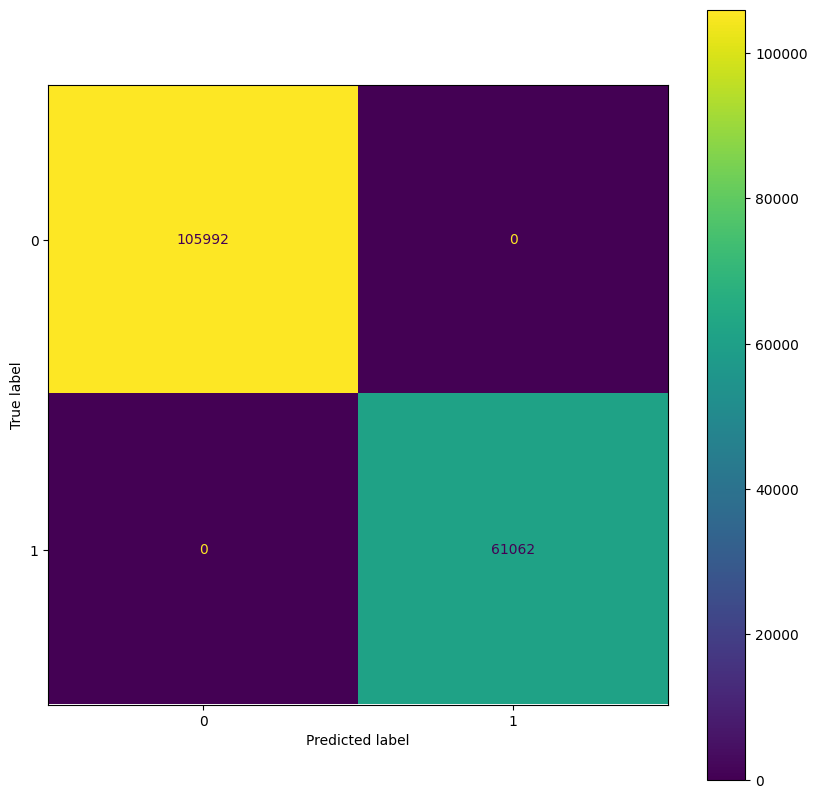

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
predict_classes = np.argmax(pred, axis = 1)
expected_classes = np.argmax(y_test, axis = 1)    
    
cm = confusion_matrix(expected_classes, predict_classes)
cmd = ConfusionMatrixDisplay(cm)

# Plot size
fig, ax = plt.subplots(figsize = (10, 10))

cmd.plot(ax = ax)

In [10]:
from sklearn.ensemble import ExtraTreesClassifier

# Usage of ExtraTreesClassifier for feature selection
extra_tree_forest = ExtraTreesClassifier(n_estimators = 5, criterion ='entropy', max_features = 2)
extra_tree_forest.fit(x, y)
feature_importance = extra_tree_forest.feature_importances_
feature_importance_normalized = np.std([tree.feature_importances_ for tree in  extra_tree_forest.estimators_], axis = 0)

print(f'[DONE] Extra Trees Classifier')

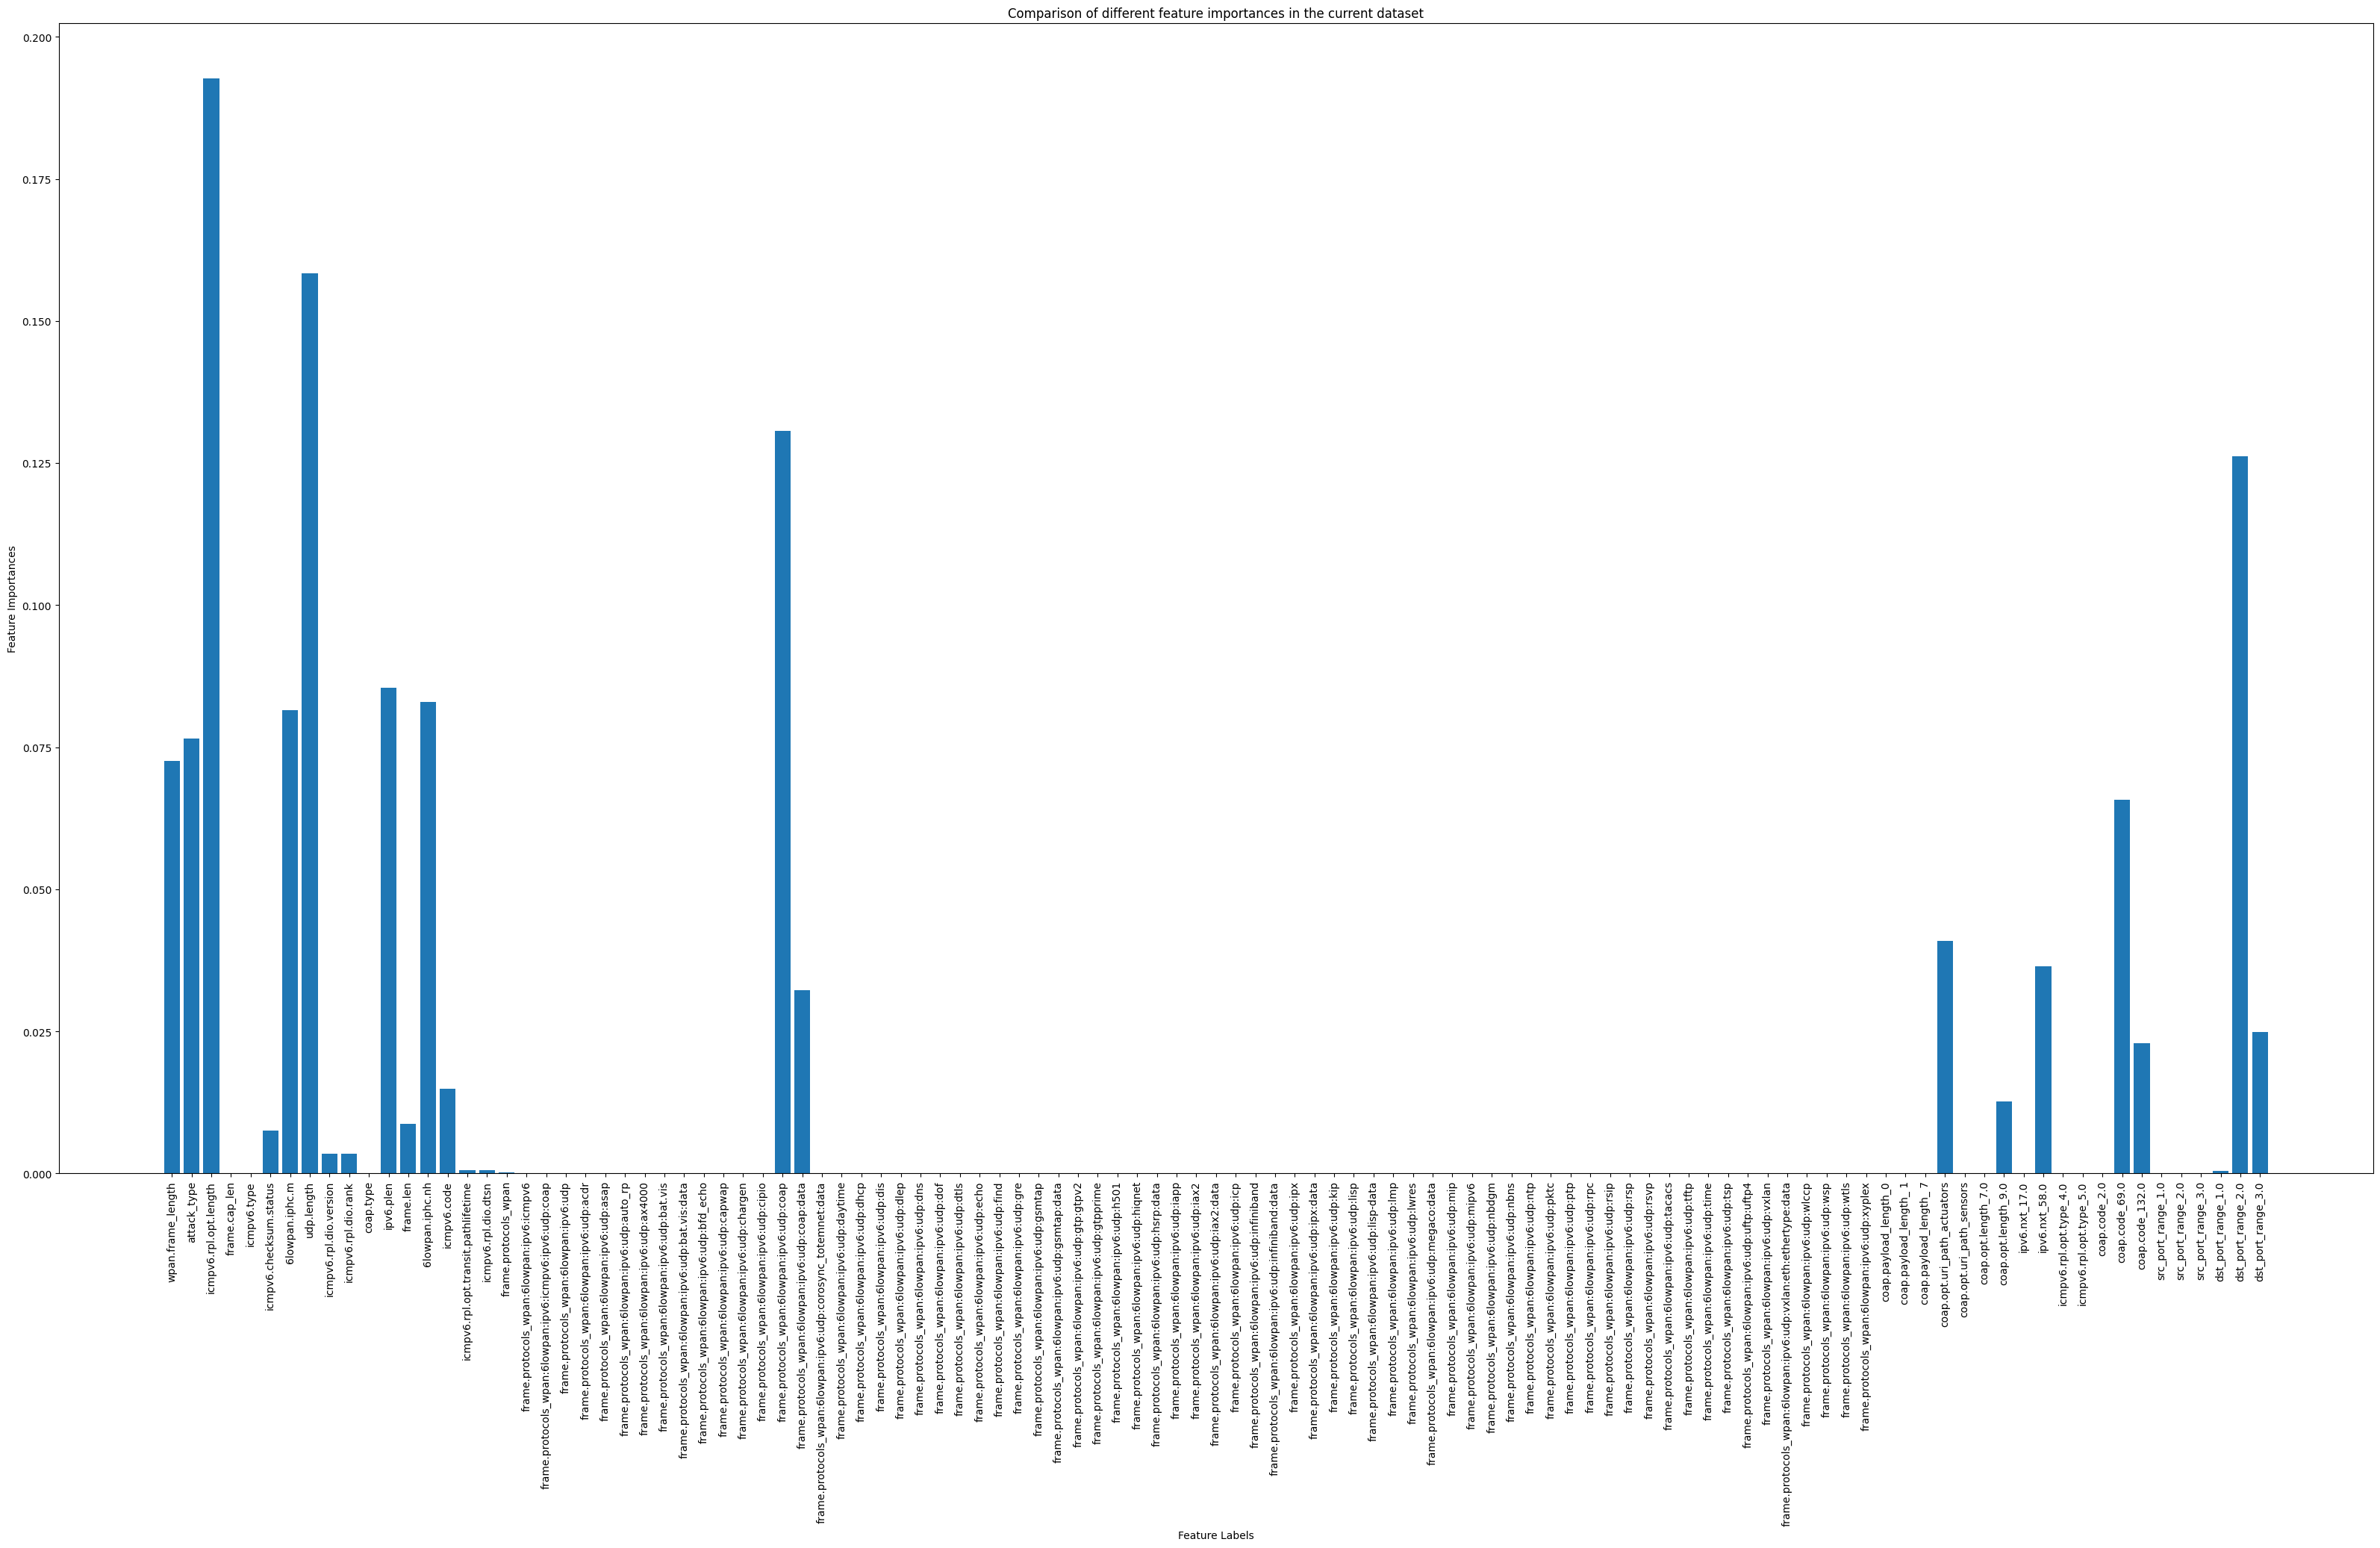

In [21]:
import matplotlib.pyplot as plt

# Plor for the ExtraTreesClassifier output
plt.bar(x_columns, feature_importance_normalized)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different feature importances in the current dataset')
plt.xticks(rotation = 90)

# Plot size
plt.rcParams["figure.figsize"] = (40, 40)

plt.show()